In [1]:
import torch, torchvision
from torch import nn
from torch.utils.data import *
from torchvision.transforms import *
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = 'cuda'

In [3]:
t1 = Compose([
    RandomHorizontalFlip(p=.5),
    RandomRotation((-0.25, +0.25)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

t2 = Compose([
    ColorJitter((0.90, 1), (0.90, 1)),
    RandomGrayscale(p=0.3),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

t3 = Compose([
    RandomResizedCrop((32, 32), ratio=(0.70, 1.3)),
    RandomRotation((-0.25, +0.25)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

tt = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

t1 = torchvision.datasets.CIFAR10(root="./", train=True, transform=t1, download=True)
t2 = torchvision.datasets.CIFAR10(root="./", train=True, transform=t2, download=True)
t3 = torchvision.datasets.CIFAR10(root="./", train=True, transform=t3, download=True)
train_data = ConcatDataset([t1, t2, t3])
test_data = torchvision.datasets.CIFAR10(root="./", train=False, transform=tt, download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

150000


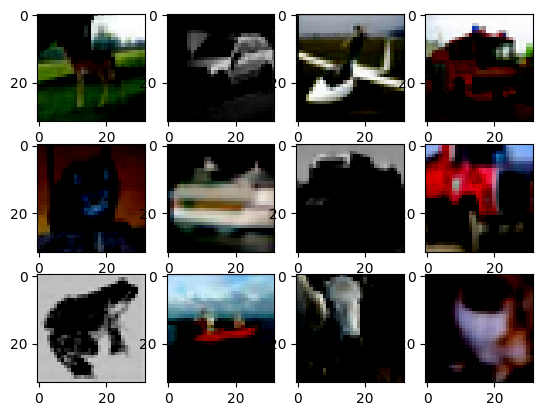

In [4]:
fig, axs = plt.subplots(3, 4)
for i in range(3):
    for j in range(4):
        axs[i][j].imshow(train_data[random.choice(range(len(train_data)))][0].numpy().transpose((1, 2, 0)))
print(len(train_data))

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Conv2d(3, 18, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(18, 32, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
        
    def forward(self, X):
        logits = self.model(X)
        return logits

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
net = Network().to(device)
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_data, batch_size=64, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=64, num_workers=4, pin_memory=True)

In [8]:
epochs = 100
for e in range(epochs):
    print(f"training epoch {e}")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    test_loop(test_dataloader, net, loss_fn)
    if e % 10 == 0 or e == 99:
        torch.save(net.state_dict(), '01.cifar-10.pth')

training epoch 0
loss: 2.311264  [   64/150000]
loss: 1.917317  [ 6464/150000]
loss: 1.654202  [12864/150000]
loss: 1.792289  [19264/150000]
loss: 1.557274  [25664/150000]
loss: 1.544401  [32064/150000]
loss: 1.513479  [38464/150000]
loss: 1.373415  [44864/150000]
loss: 1.346147  [51264/150000]
loss: 1.389546  [57664/150000]
loss: 1.357974  [64064/150000]
loss: 1.300649  [70464/150000]
loss: 1.329045  [76864/150000]
loss: 1.269755  [83264/150000]
loss: 1.350940  [89664/150000]
loss: 1.112824  [96064/150000]
loss: 1.984950  [102464/150000]
loss: 1.502107  [108864/150000]
loss: 1.664114  [115264/150000]
loss: 1.450989  [121664/150000]
loss: 1.210979  [128064/150000]
loss: 1.684574  [134464/150000]
loss: 1.367869  [140864/150000]
loss: 1.354412  [147264/150000]
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.193256 

training epoch 1
loss: 1.424752  [   64/150000]
loss: 1.011075  [ 6464/150000]
loss: 0.983315  [12864/150000]
loss: 1.028205  [19264/150000]
loss: 0.995602  [25664/150000]
loss: 1